In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

In [2]:
def load_data(file_path):
    sequences = []
    labels = []
    with open(file_path, 'r') as f:
        next(f)  # Skip the header
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                sequences.append(parts[0])
                labels.append(int(parts[1]))
    return sequences, labels

In [3]:
def build_kmer_mapping(sequences, k):
    kmer_set = set()
    for sequence in sequences:
        for i in range(len(sequence) - k + 1):
            kmer = sequence[i:i + k]
            kmer_set.add(kmer)
    kmer_to_index = {kmer: idx for idx, kmer in enumerate(sorted(kmer_set))}
    return kmer_to_index

In [4]:
def encode_sequence_with_kmers(sequence, k, max_length, kmer_to_index):
    encoded = []
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i + k]
        if kmer in kmer_to_index:
            encoded.append(kmer_to_index[kmer])
        else:
            encoded.append(0)  # Unknown k-mers assigned index 0
    if len(encoded) < max_length:
        encoded.extend([0] * (max_length - len(encoded)))
    else:
        encoded = encoded[:max_length]
    return encoded

In [23]:
class DNADataset(Dataset):
    def __init__(self, sequences, labels, max_length, kmer_to_index, k):
        self.sequences = [encode_sequence_with_kmers(seq, k, max_length, kmer_to_index) for seq in sequences]
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

In [24]:
class KmerDNAClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, max_length):
        super(KmerDNAClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # K-mer embeddings
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(0.5)

        # Calculate the output size after convolutions and pooling
        conv_output_length = max_length // 2  # First pooling
        conv_output_length = conv_output_length // 2  # Second pooling
        conv_output_length = conv_output_length // 2  # Third pooling
        self.flattened_size = conv_output_length * 128  # Channels from the last Conv1D layer

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # [batch_size, max_length, embedding_dim]
        x = x.permute(0, 2, 1)  # [batch_size, embedding_dim, max_length]
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [25]:
def train_model(model, train_loader, val_loader, num_epochs, optimizer, scheduler, criterion, device):
    model.to(device)
    best_accuracy = -float('inf')

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for sequences, labels in tqdm(train_loader):
            sequences, labels = sequences.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for sequences, labels in tqdm(val_loader):
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

        # Save the best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), "best_dna_classifier.pth")

        scheduler.step()

In [26]:
file_path = "human.txt"
sequences, labels = load_data(file_path)

In [27]:
k = 3  # Length of k-mers
max_length = 512  # Maximum sequence length (adjust based on your data)
embedding_dim = 50  # Size of the embedding vectors for k-mers
num_epochs = 20
batch_size = 32
learning_rate = 0.001

In [28]:
kmer_to_index = build_kmer_mapping(sequences, k)
vocab_size = len(kmer_to_index)

In [29]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)

In [30]:
train_dataset = DNADataset(train_sequences, train_labels, max_length, kmer_to_index, k)
val_dataset = DNADataset(val_sequences, val_labels, max_length, kmer_to_index, k)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [31]:
num_classes = len(set(labels))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KmerDNAClassifier(vocab_size=vocab_size, embedding_dim=embedding_dim, num_classes=num_classes, max_length=max_length)

In [32]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [33]:
train_model(model, train_loader, val_loader, num_epochs, optimizer, scheduler, criterion, device)

100%|██████████| 28/28 [00:00<00:00, 38.13it/s]


Epoch 1/20, Train Loss: 185.8739, Val Loss: 1.5793, Val Accuracy: 43.15%


100%|██████████| 28/28 [00:00<00:00, 37.38it/s]


Epoch 2/20, Train Loss: 123.6131, Val Loss: 1.0678, Val Accuracy: 64.61%


100%|██████████| 28/28 [00:00<00:00, 37.62it/s]


Epoch 3/20, Train Loss: 76.4802, Val Loss: 0.7888, Val Accuracy: 75.68%


100%|██████████| 28/28 [00:01<00:00, 26.99it/s]


Epoch 4/20, Train Loss: 48.2660, Val Loss: 1.1104, Val Accuracy: 70.21%


100%|██████████| 28/28 [00:01<00:00, 24.76it/s]


Epoch 5/20, Train Loss: 31.6654, Val Loss: 0.9458, Val Accuracy: 76.48%


100%|██████████| 28/28 [00:00<00:00, 36.73it/s]


Epoch 6/20, Train Loss: 20.2209, Val Loss: 0.8070, Val Accuracy: 80.37%


100%|██████████| 28/28 [00:00<00:00, 38.36it/s]


Epoch 7/20, Train Loss: 16.6171, Val Loss: 0.7907, Val Accuracy: 80.71%


100%|██████████| 28/28 [00:00<00:00, 29.14it/s]


Epoch 8/20, Train Loss: 14.1101, Val Loss: 0.9732, Val Accuracy: 80.02%


100%|██████████| 28/28 [00:00<00:00, 37.85it/s]


Epoch 9/20, Train Loss: 12.6630, Val Loss: 0.9663, Val Accuracy: 79.79%


100%|██████████| 28/28 [00:00<00:00, 38.36it/s]


Epoch 10/20, Train Loss: 14.6655, Val Loss: 0.9091, Val Accuracy: 78.42%


100%|██████████| 28/28 [00:00<00:00, 39.10it/s]


Epoch 11/20, Train Loss: 7.0403, Val Loss: 0.8124, Val Accuracy: 80.94%


100%|██████████| 28/28 [00:01<00:00, 26.06it/s]


Epoch 12/20, Train Loss: 4.4612, Val Loss: 0.8245, Val Accuracy: 81.28%


100%|██████████| 28/28 [00:00<00:00, 37.17it/s]


Epoch 13/20, Train Loss: 3.6704, Val Loss: 0.8604, Val Accuracy: 81.51%


100%|██████████| 28/28 [00:00<00:00, 38.86it/s]


Epoch 14/20, Train Loss: 2.7291, Val Loss: 0.8759, Val Accuracy: 81.39%


100%|██████████| 28/28 [00:01<00:00, 25.68it/s]


Epoch 15/20, Train Loss: 2.8008, Val Loss: 0.8652, Val Accuracy: 80.71%


100%|██████████| 28/28 [00:00<00:00, 37.03it/s]


Epoch 16/20, Train Loss: 2.9385, Val Loss: 0.9028, Val Accuracy: 80.59%


100%|██████████| 28/28 [00:00<00:00, 37.13it/s]


Epoch 17/20, Train Loss: 2.3681, Val Loss: 0.9115, Val Accuracy: 82.08%


100%|██████████| 28/28 [00:00<00:00, 36.52it/s]


Epoch 18/20, Train Loss: 2.1485, Val Loss: 0.9260, Val Accuracy: 81.39%


100%|██████████| 28/28 [00:00<00:00, 37.03it/s]


Epoch 19/20, Train Loss: 1.7695, Val Loss: 0.9393, Val Accuracy: 81.62%


100%|██████████| 28/28 [00:00<00:00, 37.93it/s]

Epoch 20/20, Train Loss: 2.1349, Val Loss: 0.9402, Val Accuracy: 80.94%


In [34]:
print("Training complete. Best model saved as 'best_dna_classifier.pth'.")

Training complete. Best model saved as 'best_dna_classifier.pth'.


In [35]:
model.load_state_dict(torch.load("best_dna_classifier.pth"))

<ipython-input-35-43f1131f57df>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_dna_classifier.pth"))


<All keys matched successfully>

In [54]:
model.eval()
val_loss = 0.0
correct = 0
total = 0
all_out = []
with torch.no_grad():
    for sequences, labels in tqdm(val_loader):
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_out += torch.flatten(predicted).tolist()

val_loss /= len(val_loader)
accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")

100%|██████████| 28/28 [00:00<00:00, 33.15it/s]

Accuracy: 82.08%


In [37]:
# Анализ показателей эффективности модели
from sklearn.metrics import accuracy_score , f1_score , precision_score , recall_score, confusion_matrix, ConfusionMatrixDisplay

def get_metrics(y_test , y_predicted):
    accuracy = accuracy_score(y_test , y_predicted)
    precision = precision_score(y_test , y_predicted , average = "weighted")
    recall = recall_score(y_test , y_predicted , average = "weighted")
    f1 = f1_score(y_test , y_predicted , average = "weighted")
    return accuracy , precision , recall , f1

In [56]:
print(len(val_labels))
print(len(all_out))
print(val_labels)
print(all_out)

876
876
[2, 0, 4, 6, 3, 6, 4, 2, 6, 6, 0, 6, 0, 6, 6, 6, 6, 1, 4, 1, 6, 3, 4, 4, 4, 6, 0, 6, 6, 6, 2, 6, 3, 6, 3, 0, 0, 6, 3, 4, 3, 0, 0, 5, 3, 0, 6, 6, 1, 2, 1, 3, 0, 5, 0, 5, 2, 6, 4, 1, 5, 1, 4, 4, 4, 4, 4, 3, 4, 2, 2, 3, 4, 5, 0, 3, 6, 1, 6, 1, 4, 1, 6, 3, 1, 6, 6, 4, 1, 2, 4, 3, 4, 3, 1, 1, 6, 6, 1, 1, 5, 1, 6, 3, 6, 4, 4, 1, 2, 0, 6, 3, 5, 4, 6, 6, 5, 6, 6, 6, 3, 0, 0, 4, 4, 1, 2, 0, 4, 6, 5, 2, 5, 6, 1, 2, 4, 4, 6, 1, 3, 2, 3, 5, 6, 6, 1, 5, 6, 4, 3, 6, 6, 6, 6, 2, 3, 6, 0, 6, 6, 3, 1, 0, 5, 2, 4, 2, 1, 4, 5, 4, 6, 6, 6, 6, 6, 3, 4, 4, 2, 2, 1, 1, 2, 6, 6, 6, 6, 0, 4, 0, 4, 2, 1, 2, 3, 0, 6, 4, 6, 1, 2, 1, 4, 4, 3, 5, 6, 4, 6, 0, 4, 1, 0, 1, 3, 3, 5, 6, 6, 0, 0, 6, 3, 0, 0, 6, 5, 2, 0, 1, 5, 3, 1, 1, 6, 6, 1, 3, 2, 4, 3, 6, 6, 3, 4, 6, 4, 4, 0, 3, 4, 3, 6, 1, 4, 6, 6, 6, 6, 0, 0, 6, 6, 6, 6, 4, 4, 3, 3, 1, 4, 6, 4, 6, 4, 2, 3, 2, 6, 3, 3, 6, 2, 6, 6, 1, 1, 5, 0, 5, 3, 1, 3, 6, 2, 2, 4, 1, 6, 6, 4, 4, 4, 4, 3, 6, 4, 4, 3, 3, 6, 3, 2, 6, 4, 2, 6, 0, 4, 3, 6, 3, 5, 6, 6, 6, 6, 1, 1

accuracy = 0.821 
precision = 0.826 
recall = 0.821 
f1 = 0.819 



Text(0.5, 1.0, 'Confusion Matrix')

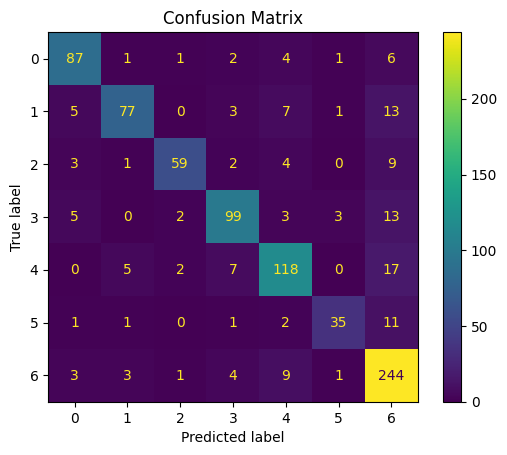

In [58]:
import matplotlib.pyplot as plt

knn_accuracy , knn_precision , knn_recall , knn_f1 = get_metrics(val_labels, all_out)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f \n" % (knn_accuracy , knn_precision , knn_recall , knn_f1))

model_matrix_ = confusion_matrix(val_labels, all_out, labels=[0, 1, 2, 3, 4, 5, 6])
model_mat_plt_ = ConfusionMatrixDisplay(confusion_matrix=model_matrix_)
model_mat_plt_.plot()
plt.title('Confusion Matrix')